In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[15].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.69it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.04it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 14/2000 [00:00<01:11, 27.94it/s]

Epoch 10/2000, Loss: 0.5354
Test Accuracy at Epoch 10: 65.00%
Test F1-score at Epoch 10: 0.6885
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.52      0.60       194
non_infringement       0.61      0.79      0.69       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.64       380
    weighted avg       0.67      0.65      0.64       380

New best model saved with F1-score 0.6885 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.52      0.60       194
non_infringement       0.61      0.79      0.69       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.64       380
    weighted avg       0.67      0.65      0.64       380



Training Epochs:   1%|          | 23/2000 [00:00<00:58, 33.85it/s]

Epoch 20/2000, Loss: 0.3940
Test Accuracy at Epoch 20: 67.89%
Test F1-score at Epoch 20: 0.7095
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.56      0.64       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.67       380

New best model saved with F1-score 0.7095 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.56      0.64       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:   2%|▏         | 38/2000 [00:01<00:49, 39.84it/s]

Epoch 30/2000, Loss: 0.3369
Test Accuracy at Epoch 30: 71.05%
Test F1-score at Epoch 30: 0.7406
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.80      0.58      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.71       380
    weighted avg       0.73      0.71      0.71       380

New best model saved with F1-score 0.7406 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.80      0.58      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   2%|▏         | 43/2000 [00:01<00:57, 34.04it/s]

Epoch 40/2000, Loss: 0.3055
Test Accuracy at Epoch 40: 71.84%
Test F1-score at Epoch 40: 0.7409
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

New best model saved with F1-score 0.7409 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   3%|▎         | 60/2000 [00:01<00:42, 45.87it/s]

Epoch 50/2000, Loss: 0.2768
Test Accuracy at Epoch 50: 70.26%
Test F1-score at Epoch 50: 0.7210
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

Epoch 60/2000, Loss: 0.2413
Test Accuracy at Epoch 60: 71.58%
Test F1-score at Epoch 60: 0.7353
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.77      0.63      0.69       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:   4%|▍         | 76/2000 [00:02<00:40, 47.32it/s]

Epoch 70/2000, Loss: 0.2142
Test Accuracy at Epoch 70: 73.68%
Test F1-score at Epoch 70: 0.7685
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380

New best model saved with F1-score 0.7685 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:   4%|▍         | 86/2000 [00:02<00:46, 41.42it/s]

Epoch 80/2000, Loss: 0.1829
Test Accuracy at Epoch 80: 73.42%
Test F1-score at Epoch 80: 0.7646
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:   5%|▍         | 96/2000 [00:02<00:47, 39.85it/s]

Epoch 90/2000, Loss: 0.1644
Test Accuracy at Epoch 90: 73.95%
Test F1-score at Epoch 90: 0.7703
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380

New best model saved with F1-score 0.7703 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380



Training Epochs:   5%|▌         | 109/2000 [00:02<00:38, 49.43it/s]

Epoch 100/2000, Loss: 0.1471
Test Accuracy at Epoch 100: 73.68%
Test F1-score at Epoch 100: 0.7674
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380

Epoch 110/2000, Loss: 0.1433
Test Accuracy at Epoch 110: 76.84%
Test F1-score at Epoch 110: 0.7811
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.75       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1

Training Epochs:   6%|▋         | 128/2000 [00:03<00:37, 49.32it/s]

Epoch 120/2000, Loss: 0.1366
Test Accuracy at Epoch 120: 73.16%
Test F1-score at Epoch 120: 0.7617
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 130/2000, Loss: 0.1307
Test Accuracy at Epoch 130: 73.16%
Test F1-score at Epoch 130: 0.7617
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:   7%|▋         | 144/2000 [00:03<00:43, 43.12it/s]

Epoch 140/2000, Loss: 0.1304
Test Accuracy at Epoch 140: 78.42%
Test F1-score at Epoch 140: 0.7940
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.72      0.77       194
non_infringement       0.75      0.85      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7940 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.72      0.77       194
non_infringement       0.75      0.85      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   8%|▊         | 154/2000 [00:03<00:44, 41.71it/s]

Epoch 150/2000, Loss: 0.1283
Test Accuracy at Epoch 150: 74.74%
Test F1-score at Epoch 150: 0.7725
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:   8%|▊         | 166/2000 [00:04<00:44, 40.86it/s]

Epoch 160/2000, Loss: 0.1263
Test Accuracy at Epoch 160: 78.42%
Test F1-score at Epoch 160: 0.7929
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.83      0.73      0.77       194
non_infringement       0.75      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   9%|▉         | 177/2000 [00:04<00:41, 44.16it/s]

Epoch 170/2000, Loss: 0.1203
Test Accuracy at Epoch 170: 73.16%
Test F1-score at Epoch 170: 0.7548
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:   9%|▉         | 182/2000 [00:04<00:45, 39.67it/s]

Epoch 180/2000, Loss: 0.1188
Test Accuracy at Epoch 180: 74.47%
Test F1-score at Epoch 180: 0.7707
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  10%|▉         | 191/2000 [00:04<00:54, 33.11it/s]

Epoch 190/2000, Loss: 0.1203
Test Accuracy at Epoch 190: 79.21%
Test F1-score at Epoch 190: 0.7990
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.74      0.78       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.7990 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.74      0.78       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  10%|█         | 202/2000 [00:05<01:08, 26.25it/s]

Epoch 200/2000, Loss: 0.1145
Test Accuracy at Epoch 200: 76.84%
Test F1-score at Epoch 200: 0.7811
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.75       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  11%|█         | 217/2000 [00:05<00:47, 37.70it/s]

Epoch 210/2000, Loss: 0.1134
Test Accuracy at Epoch 210: 74.21%
Test F1-score at Epoch 210: 0.7656
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  11%|█▏        | 227/2000 [00:05<00:46, 38.01it/s]

Epoch 220/2000, Loss: 0.1135
Test Accuracy at Epoch 220: 79.74%
Test F1-score at Epoch 220: 0.8031
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380

New best model saved with F1-score 0.8031 at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  12%|█▏        | 232/2000 [00:06<00:44, 39.75it/s]

Epoch 230/2000, Loss: 0.1129
Test Accuracy at Epoch 230: 73.95%
Test F1-score at Epoch 230: 0.7637
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.86      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  12%|█▏        | 247/2000 [00:06<00:40, 43.18it/s]

Epoch 240/2000, Loss: 0.1104
Test Accuracy at Epoch 240: 80.00%
Test F1-score at Epoch 240: 0.8061
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.84      0.75      0.79       194
non_infringement       0.77      0.85      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380

New best model saved with F1-score 0.8061 at epoch 240
Best Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.84      0.75      0.79       194
non_infringement       0.77      0.85      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  13%|█▎        | 252/2000 [00:06<00:46, 37.78it/s]

Epoch 250/2000, Loss: 0.1082
Test Accuracy at Epoch 250: 74.21%
Test F1-score at Epoch 250: 0.7656
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  13%|█▎        | 262/2000 [00:06<00:41, 41.69it/s]

Epoch 260/2000, Loss: 0.1075
Test Accuracy at Epoch 260: 80.00%
Test F1-score at Epoch 260: 0.8061
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.84      0.75      0.79       194
non_infringement       0.77      0.85      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  14%|█▍        | 280/2000 [00:07<00:36, 46.81it/s]

Epoch 270/2000, Loss: 0.1064
Test Accuracy at Epoch 270: 76.32%
Test F1-score at Epoch 270: 0.7805
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.86      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 280/2000, Loss: 0.1077
Test Accuracy at Epoch 280: 76.84%
Test F1-score at Epoch 280: 0.7864
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.84      0.67      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  15%|█▌        | 300/2000 [00:07<00:32, 52.24it/s]

Epoch 290/2000, Loss: 0.1086
Test Accuracy at Epoch 290: 79.47%
Test F1-score at Epoch 290: 0.7979
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.82      0.76      0.79       194
non_infringement       0.77      0.83      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

Epoch 300/2000, Loss: 0.1077
Test Accuracy at Epoch 300: 74.21%
Test F1-score at Epoch 300: 0.7678
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  16%|█▌        | 314/2000 [00:07<00:31, 53.42it/s]

Epoch 310/2000, Loss: 0.1073
Test Accuracy at Epoch 310: 79.47%
Test F1-score at Epoch 310: 0.7979
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.82      0.76      0.79       194
non_infringement       0.77      0.83      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

Epoch 320/2000, Loss: 0.1052
Test Accuracy at Epoch 320: 74.21%
Test F1-score at Epoch 320: 0.7678
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  17%|█▋        | 335/2000 [00:08<00:31, 53.53it/s]

Epoch 330/2000, Loss: 0.1031
Test Accuracy at Epoch 330: 76.05%
Test F1-score at Epoch 330: 0.7742
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  18%|█▊        | 350/2000 [00:08<00:28, 58.11it/s]

Epoch 340/2000, Loss: 0.1089
Test Accuracy at Epoch 340: 78.42%
Test F1-score at Epoch 340: 0.7865
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.81      0.76      0.78       194
non_infringement       0.76      0.81      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

Epoch 350/2000, Loss: 0.1080
Test Accuracy at Epoch 350: 74.21%
Test F1-score at Epoch 350: 0.7678
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  18%|█▊        | 369/2000 [00:08<00:28, 56.68it/s]

Epoch 360/2000, Loss: 0.1030
Test Accuracy at Epoch 360: 75.79%
Test F1-score at Epoch 360: 0.7723
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 370/2000, Loss: 0.1023
Test Accuracy at Epoch 370: 77.89%
Test F1-score at Epoch 370: 0.7879
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.82      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  19%|█▉        | 388/2000 [00:09<00:29, 54.89it/s]

Epoch 380/2000, Loss: 0.1035
Test Accuracy at Epoch 380: 73.16%
Test F1-score at Epoch 380: 0.7536
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 390/2000, Loss: 0.1024
Test Accuracy at Epoch 390: 77.63%
Test F1-score at Epoch 390: 0.7859
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.82      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  20%|██        | 408/2000 [00:09<00:29, 53.89it/s]

Epoch 400/2000, Loss: 0.1007
Test Accuracy at Epoch 400: 74.74%
Test F1-score at Epoch 400: 0.7647
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 410/2000, Loss: 0.1054
Test Accuracy at Epoch 410: 72.37%
Test F1-score at Epoch 410: 0.7482
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  21%|██▏       | 428/2000 [00:09<00:28, 54.25it/s]

Epoch 420/2000, Loss: 0.1046
Test Accuracy at Epoch 420: 77.11%
Test F1-score at Epoch 420: 0.7797
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 430/2000, Loss: 0.1047
Test Accuracy at Epoch 430: 73.16%
Test F1-score at Epoch 430: 0.7536


Training Epochs:  22%|██▏       | 434/2000 [00:10<00:28, 54.61it/s]

Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 440/2000, Loss: 0.1021
Test Accuracy at Epoch 440: 76.84%
Test F1-score at Epoch 440: 0.7800
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  23%|██▎       | 460/2000 [00:10<00:28, 53.82it/s]

Epoch 450/2000, Loss: 0.1002
Test Accuracy at Epoch 450: 77.11%
Test F1-score at Epoch 450: 0.7820
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 460/2000, Loss: 0.1000
Test Accuracy at Epoch 460: 73.16%
Test F1-score at Epoch 460: 0.7536
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  24%|██▍       | 480/2000 [00:10<00:26, 58.21it/s]

Epoch 470/2000, Loss: 0.1000
Test Accuracy at Epoch 470: 77.11%
Test F1-score at Epoch 470: 0.7820
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 480/2000, Loss: 0.0996
Test Accuracy at Epoch 480: 74.21%
Test F1-score at Epoch 480: 0.7610
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  25%|██▍       | 499/2000 [00:11<00:27, 55.13it/s]

Epoch 490/2000, Loss: 0.1005
Test Accuracy at Epoch 490: 75.79%
Test F1-score at Epoch 490: 0.7723
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 500/2000, Loss: 0.0989
Test Accuracy at Epoch 500: 74.21%
Test F1-score at Epoch 500: 0.7610
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  26%|██▌       | 518/2000 [00:11<00:27, 54.48it/s]

Epoch 510/2000, Loss: 0.0984
Test Accuracy at Epoch 510: 75.53%
Test F1-score at Epoch 510: 0.7704
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 520/2000, Loss: 0.0998
Test Accuracy at Epoch 520: 77.63%
Test F1-score at Epoch 520: 0.7859
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.82      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  27%|██▋       | 539/2000 [00:11<00:25, 57.96it/s]

Epoch 530/2000, Loss: 0.0982
Test Accuracy at Epoch 530: 74.21%
Test F1-score at Epoch 530: 0.7610
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 540/2000, Loss: 0.1030
Test Accuracy at Epoch 540: 73.68%
Test F1-score at Epoch 540: 0.7573
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  28%|██▊       | 559/2000 [00:12<00:26, 53.86it/s]

Epoch 550/2000, Loss: 0.0992
Test Accuracy at Epoch 550: 76.84%
Test F1-score at Epoch 550: 0.7800
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 560/2000, Loss: 0.0988
Test Accuracy at Epoch 560: 77.63%
Test F1-score at Epoch 560: 0.7859
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.82      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  29%|██▉       | 577/2000 [00:12<00:29, 48.98it/s]

Epoch 570/2000, Loss: 0.1007
Test Accuracy at Epoch 570: 72.63%
Test F1-score at Epoch 570: 0.7500
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380

Epoch 580/2000, Loss: 0.0976
Test Accuracy at Epoch 580: 74.74%
Test F1-score at Epoch 580: 0.7647


Training Epochs:  29%|██▉       | 583/2000 [00:12<00:28, 49.40it/s]

Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  30%|██▉       | 594/2000 [00:13<00:30, 45.96it/s]

Epoch 590/2000, Loss: 0.0973
Test Accuracy at Epoch 590: 75.26%
Test F1-score at Epoch 590: 0.7685
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 600/2000, Loss: 0.0980
Test Accuracy at Epoch 600: 76.84%
Test F1-score at Epoch 600: 0.7800


Training Epochs:  30%|███       | 605/2000 [00:13<00:34, 40.36it/s]

Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.76       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  31%|███       | 616/2000 [00:13<00:30, 45.14it/s]

Epoch 610/2000, Loss: 0.0971
Test Accuracy at Epoch 610: 74.21%
Test F1-score at Epoch 610: 0.7610
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  31%|███▏      | 627/2000 [00:13<00:31, 43.65it/s]

Epoch 620/2000, Loss: 0.1013
Test Accuracy at Epoch 620: 72.63%
Test F1-score at Epoch 620: 0.7500
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  32%|███▏      | 637/2000 [00:14<00:32, 41.41it/s]

Epoch 630/2000, Loss: 0.1055
Test Accuracy at Epoch 630: 75.79%
Test F1-score at Epoch 630: 0.7653
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 648/2000 [00:14<00:30, 43.70it/s]

Epoch 640/2000, Loss: 0.0981
Test Accuracy at Epoch 640: 74.74%
Test F1-score at Epoch 640: 0.7647
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  33%|███▎      | 653/2000 [00:14<00:34, 38.89it/s]

Epoch 650/2000, Loss: 0.0985
Test Accuracy at Epoch 650: 73.95%
Test F1-score at Epoch 650: 0.7603
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  33%|███▎      | 665/2000 [00:14<00:29, 45.90it/s]

Epoch 660/2000, Loss: 0.0999
Test Accuracy at Epoch 660: 75.00%
Test F1-score at Epoch 660: 0.7654
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 670/2000, Loss: 0.0970
Test Accuracy at Epoch 670: 76.84%
Test F1-score at Epoch 670: 0.7789
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.82      0.71      0.76       194
non_infringement       0.73      0.83      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  34%|███▍      | 690/2000 [00:15<00:25, 50.41it/s]

Epoch 680/2000, Loss: 0.0984
Test Accuracy at Epoch 680: 72.37%
Test F1-score at Epoch 680: 0.7494
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       194
non_infringement       0.67      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380

Epoch 690/2000, Loss: 0.0963
Test Accuracy at Epoch 690: 73.68%
Test F1-score at Epoch 690: 0.7573
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  35%|███▌      | 709/2000 [00:15<00:23, 54.30it/s]

Epoch 700/2000, Loss: 0.0970
Test Accuracy at Epoch 700: 76.32%
Test F1-score at Epoch 700: 0.7750
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.72      0.83      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 710/2000, Loss: 0.0969
Test Accuracy at Epoch 710: 73.95%
Test F1-score at Epoch 710: 0.7603
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  36%|███▋      | 728/2000 [00:16<00:23, 55.00it/s]

Epoch 720/2000, Loss: 0.0964
Test Accuracy at Epoch 720: 74.47%
Test F1-score at Epoch 720: 0.7617
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 730/2000, Loss: 0.0960
Test Accuracy at Epoch 730: 74.47%
Test F1-score at Epoch 730: 0.7628
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  37%|███▋      | 747/2000 [00:16<00:22, 55.42it/s]

Epoch 740/2000, Loss: 0.0968
Test Accuracy at Epoch 740: 73.95%
Test F1-score at Epoch 740: 0.7603
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 750/2000, Loss: 0.0966
Test Accuracy at Epoch 750: 74.21%
Test F1-score at Epoch 750: 0.7621
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  39%|███▊      | 771/2000 [00:16<00:23, 52.87it/s]

Epoch 760/2000, Loss: 0.1038
Test Accuracy at Epoch 760: 76.32%
Test F1-score at Epoch 760: 0.7739
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       194
non_infringement       0.73      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 770/2000, Loss: 0.0987
Test Accuracy at Epoch 770: 73.95%
Test F1-score at Epoch 770: 0.7603
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  40%|███▉      | 790/2000 [00:17<00:22, 54.88it/s]

Epoch 780/2000, Loss: 0.1002
Test Accuracy at Epoch 780: 73.95%
Test F1-score at Epoch 780: 0.7692
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380

Epoch 790/2000, Loss: 0.0971
Test Accuracy at Epoch 790: 74.74%
Test F1-score at Epoch 790: 0.7659
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  40%|████      | 810/2000 [00:17<00:20, 57.07it/s]

Epoch 800/2000, Loss: 0.0972
Test Accuracy at Epoch 800: 76.58%
Test F1-score at Epoch 800: 0.7781
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.75       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.76       380

Epoch 810/2000, Loss: 0.0957
Test Accuracy at Epoch 810: 74.74%
Test F1-score at Epoch 810: 0.7647
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  42%|████▏     | 831/2000 [00:17<00:20, 56.00it/s]

Epoch 820/2000, Loss: 0.0955
Test Accuracy at Epoch 820: 74.47%
Test F1-score at Epoch 820: 0.7628
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 830/2000, Loss: 0.0953
Test Accuracy at Epoch 830: 73.68%
Test F1-score at Epoch 830: 0.7573
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  42%|████▏     | 846/2000 [00:18<00:21, 54.31it/s]

Epoch 840/2000, Loss: 0.0952
Test Accuracy at Epoch 840: 74.74%
Test F1-score at Epoch 840: 0.7647
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  43%|████▎     | 859/2000 [00:18<00:19, 57.26it/s]

Epoch 850/2000, Loss: 0.0951
Test Accuracy at Epoch 850: 74.74%
Test F1-score at Epoch 850: 0.7659
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 860/2000, Loss: 0.0951
Test Accuracy at Epoch 860: 74.21%
Test F1-score at Epoch 860: 0.7621
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  44%|████▍     | 878/2000 [00:18<00:19, 56.95it/s]

Epoch 870/2000, Loss: 0.0953
Test Accuracy at Epoch 870: 74.21%
Test F1-score at Epoch 870: 0.7633
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 880/2000, Loss: 0.0965
Test Accuracy at Epoch 880: 74.21%
Test F1-score at Epoch 880: 0.7633
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  45%|████▍     | 897/2000 [00:19<00:19, 55.67it/s]

Epoch 890/2000, Loss: 0.0968
Test Accuracy at Epoch 890: 75.00%
Test F1-score at Epoch 890: 0.7677
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 900/2000, Loss: 0.0951
Test Accuracy at Epoch 900: 74.47%
Test F1-score at Epoch 900: 0.7628
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       194
non_infringement       0.70      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  46%|████▌     | 917/2000 [00:19<00:19, 55.25it/s]

Epoch 910/2000, Loss: 0.0964
Test Accuracy at Epoch 910: 77.37%
Test F1-score at Epoch 910: 0.7923
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380

Epoch 920/2000, Loss: 0.1055
Test Accuracy at Epoch 920: 76.58%
Test F1-score at Epoch 920: 0.7781
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.75       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:  47%|████▋     | 936/2000 [00:19<00:22, 47.99it/s]

Epoch 930/2000, Loss: 0.0970
Test Accuracy at Epoch 930: 76.32%
Test F1-score at Epoch 930: 0.7783
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.82      0.68      0.75       194
non_infringement       0.72      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  47%|████▋     | 948/2000 [00:20<00:21, 48.63it/s]

Epoch 940/2000, Loss: 0.0960
Test Accuracy at Epoch 940: 73.68%
Test F1-score at Epoch 940: 0.7664
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.84      0.60      0.70       194
non_infringement       0.68      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  48%|████▊     | 961/2000 [00:20<00:19, 53.96it/s]

Epoch 950/2000, Loss: 0.0950
Test Accuracy at Epoch 950: 74.47%
Test F1-score at Epoch 950: 0.7651
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 960/2000, Loss: 0.0949
Test Accuracy at Epoch 960: 75.26%
Test F1-score at Epoch 960: 0.7707
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.71      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  49%|████▉     | 976/2000 [00:20<00:19, 52.56it/s]

Epoch 970/2000, Loss: 0.0946
Test Accuracy at Epoch 970: 75.26%
Test F1-score at Epoch 970: 0.7707
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.71      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 980/2000, Loss: 0.0946
Test Accuracy at Epoch 980: 75.53%
Test F1-score at Epoch 980: 0.7791
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  50%|████▉     | 995/2000 [00:21<00:19, 50.75it/s]

Epoch 990/2000, Loss: 0.0945
Test Accuracy at Epoch 990: 76.32%
Test F1-score at Epoch 990: 0.7847
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  50%|█████     | 1010/2000 [00:21<00:17, 55.99it/s]

Epoch 1000/2000, Loss: 0.0944
Test Accuracy at Epoch 1000: 75.53%
Test F1-score at Epoch 1000: 0.7791
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380

Epoch 1010/2000, Loss: 0.0944
Test Accuracy at Epoch 1010: 75.53%
Test F1-score at Epoch 1010: 0.7791
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  51%|█████▏    | 1028/2000 [00:21<00:18, 51.48it/s]

Epoch 1020/2000, Loss: 0.0944
Test Accuracy at Epoch 1020: 75.53%
Test F1-score at Epoch 1020: 0.7791
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380

Epoch 1030/2000, Loss: 0.0982
Test Accuracy at Epoch 1030: 73.16%
Test F1-score at Epoch 1030: 0.7628


Training Epochs:  52%|█████▏    | 1034/2000 [00:21<00:22, 42.31it/s]

Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  52%|█████▏    | 1046/2000 [00:22<00:20, 45.96it/s]

Epoch 1040/2000, Loss: 0.0962
Test Accuracy at Epoch 1040: 75.79%
Test F1-score at Epoch 1040: 0.7688
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  53%|█████▎    | 1057/2000 [00:22<00:21, 44.68it/s]

Epoch 1050/2000, Loss: 0.0957
Test Accuracy at Epoch 1050: 73.16%
Test F1-score at Epoch 1050: 0.7628
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 1060/2000, Loss: 0.0961
Test Accuracy at Epoch 1060: 75.26%
Test F1-score at Epoch 1060: 0.7696


Training Epochs:  53%|█████▎    | 1067/2000 [00:22<00:22, 41.96it/s]

Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  54%|█████▍    | 1078/2000 [00:22<00:20, 45.49it/s]

Epoch 1070/2000, Loss: 0.1056
Test Accuracy at Epoch 1070: 72.37%
Test F1-score at Epoch 1070: 0.7458
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  54%|█████▍    | 1083/2000 [00:23<00:23, 39.02it/s]

Epoch 1080/2000, Loss: 0.1249
Test Accuracy at Epoch 1080: 75.00%
Test F1-score at Epoch 1080: 0.7558
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  55%|█████▍    | 1094/2000 [00:23<00:21, 42.96it/s]

Epoch 1090/2000, Loss: 0.1048
Test Accuracy at Epoch 1090: 74.74%
Test F1-score at Epoch 1090: 0.7563
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1104/2000 [00:23<00:23, 37.35it/s]

Epoch 1100/2000, Loss: 0.1071
Test Accuracy at Epoch 1100: 75.53%
Test F1-score at Epoch 1100: 0.7737
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.73       194
non_infringement       0.71      0.85      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  56%|█████▌    | 1115/2000 [00:23<00:22, 39.33it/s]

Epoch 1110/2000, Loss: 0.0970
Test Accuracy at Epoch 1110: 73.68%
Test F1-score at Epoch 1110: 0.7608
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  56%|█████▋    | 1127/2000 [00:24<00:18, 46.82it/s]

Epoch 1120/2000, Loss: 0.0953
Test Accuracy at Epoch 1120: 72.37%
Test F1-score at Epoch 1120: 0.7494
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       194
non_infringement       0.67      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380

Epoch 1130/2000, Loss: 0.0949
Test Accuracy at Epoch 1130: 72.37%
Test F1-score at Epoch 1130: 0.7518
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  57%|█████▋    | 1148/2000 [00:24<00:19, 44.32it/s]

Epoch 1140/2000, Loss: 0.0945
Test Accuracy at Epoch 1140: 73.68%
Test F1-score at Epoch 1140: 0.7608
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  58%|█████▊    | 1159/2000 [00:24<00:20, 41.65it/s]

Epoch 1150/2000, Loss: 0.0943
Test Accuracy at Epoch 1150: 73.95%
Test F1-score at Epoch 1150: 0.7626
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1160/2000, Loss: 0.0942


Training Epochs:  58%|█████▊    | 1164/2000 [00:24<00:21, 38.39it/s]

Test Accuracy at Epoch 1160: 74.21%
Test F1-score at Epoch 1160: 0.7644
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  59%|█████▉    | 1177/2000 [00:25<00:16, 48.72it/s]

Epoch 1170/2000, Loss: 0.0942
Test Accuracy at Epoch 1170: 74.21%
Test F1-score at Epoch 1170: 0.7644
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1180/2000, Loss: 0.0942
Test Accuracy at Epoch 1180: 74.47%
Test F1-score at Epoch 1180: 0.7663
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  60%|██████    | 1201/2000 [00:25<00:15, 51.54it/s]

Epoch 1190/2000, Loss: 0.0941
Test Accuracy at Epoch 1190: 74.21%
Test F1-score at Epoch 1190: 0.7644
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1200/2000, Loss: 0.0941
Test Accuracy at Epoch 1200: 74.21%
Test F1-score at Epoch 1200: 0.7644
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  61%|██████    | 1221/2000 [00:26<00:14, 55.00it/s]

Epoch 1210/2000, Loss: 0.0940
Test Accuracy at Epoch 1210: 74.21%
Test F1-score at Epoch 1210: 0.7644
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1220/2000, Loss: 0.0940
Test Accuracy at Epoch 1220: 74.21%
Test F1-score at Epoch 1220: 0.7644
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  62%|██████▏   | 1242/2000 [00:26<00:12, 58.63it/s]

Epoch 1230/2000, Loss: 0.0940
Test Accuracy at Epoch 1230: 74.21%
Test F1-score at Epoch 1230: 0.7644
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1240/2000, Loss: 0.0939
Test Accuracy at Epoch 1240: 74.21%
Test F1-score at Epoch 1240: 0.7644
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1257/2000 [00:26<00:13, 54.32it/s]

Epoch 1250/2000, Loss: 0.0939
Test Accuracy at Epoch 1250: 74.21%
Test F1-score at Epoch 1250: 0.7644
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  64%|██████▎   | 1271/2000 [00:26<00:12, 58.73it/s]

Epoch 1260/2000, Loss: 0.0939
Test Accuracy at Epoch 1260: 74.21%
Test F1-score at Epoch 1260: 0.7644
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1270/2000, Loss: 0.0938
Test Accuracy at Epoch 1270: 74.21%
Test F1-score at Epoch 1270: 0.7644
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  65%|██████▍   | 1292/2000 [00:27<00:11, 59.81it/s]

Epoch 1280/2000, Loss: 0.0938
Test Accuracy at Epoch 1280: 74.21%
Test F1-score at Epoch 1280: 0.7644
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1290/2000, Loss: 0.0938
Test Accuracy at Epoch 1290: 74.21%
Test F1-score at Epoch 1290: 0.7644
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  65%|██████▌   | 1306/2000 [00:27<00:12, 57.43it/s]

Epoch 1300/2000, Loss: 0.0938
Test Accuracy at Epoch 1300: 74.21%
Test F1-score at Epoch 1300: 0.7644
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1310/2000, Loss: 0.0937
Test Accuracy at Epoch 1310: 74.21%
Test F1-score at Epoch 1310: 0.7644
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  67%|██████▋   | 1331/2000 [00:27<00:12, 54.75it/s]

Epoch 1320/2000, Loss: 0.0937
Test Accuracy at Epoch 1320: 74.21%
Test F1-score at Epoch 1320: 0.7644
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1330/2000, Loss: 0.0937
Test Accuracy at Epoch 1330: 74.21%
Test F1-score at Epoch 1330: 0.7644
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  67%|██████▋   | 1344/2000 [00:28<00:12, 50.53it/s]

Epoch 1340/2000, Loss: 0.0936
Test Accuracy at Epoch 1340: 74.21%
Test F1-score at Epoch 1340: 0.7644
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  68%|██████▊   | 1359/2000 [00:28<00:10, 59.74it/s]

Epoch 1350/2000, Loss: 0.0936
Test Accuracy at Epoch 1350: 74.21%
Test F1-score at Epoch 1350: 0.7644
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1360/2000, Loss: 0.0936
Test Accuracy at Epoch 1360: 74.21%
Test F1-score at Epoch 1360: 0.7644
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  69%|██████▉   | 1380/2000 [00:28<00:10, 56.68it/s]

Epoch 1370/2000, Loss: 0.0936
Test Accuracy at Epoch 1370: 74.21%
Test F1-score at Epoch 1370: 0.7644
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1380/2000, Loss: 0.0935
Test Accuracy at Epoch 1380: 74.21%
Test F1-score at Epoch 1380: 0.7644
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  70%|██████▉   | 1399/2000 [00:29<00:10, 57.07it/s]

Epoch 1390/2000, Loss: 0.0935
Test Accuracy at Epoch 1390: 74.21%
Test F1-score at Epoch 1390: 0.7644
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1400/2000, Loss: 0.0935
Test Accuracy at Epoch 1400: 74.21%
Test F1-score at Epoch 1400: 0.7644
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  71%|███████   | 1420/2000 [00:29<00:10, 56.86it/s]

Epoch 1410/2000, Loss: 0.0935
Test Accuracy at Epoch 1410: 74.21%
Test F1-score at Epoch 1410: 0.7644
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1420/2000, Loss: 0.0934
Test Accuracy at Epoch 1420: 74.21%
Test F1-score at Epoch 1420: 0.7644
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  72%|███████▏  | 1442/2000 [00:29<00:09, 57.07it/s]

Epoch 1430/2000, Loss: 0.0934
Test Accuracy at Epoch 1430: 74.21%
Test F1-score at Epoch 1430: 0.7644
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1440/2000, Loss: 0.0934
Test Accuracy at Epoch 1440: 73.68%
Test F1-score at Epoch 1440: 0.7608
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  73%|███████▎  | 1455/2000 [00:30<00:10, 50.13it/s]

Epoch 1450/2000, Loss: 0.0935
Test Accuracy at Epoch 1450: 73.68%
Test F1-score at Epoch 1450: 0.7608
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  73%|███████▎  | 1467/2000 [00:30<00:10, 52.36it/s]

Epoch 1460/2000, Loss: 0.0947
Test Accuracy at Epoch 1460: 73.68%
Test F1-score at Epoch 1460: 0.7608
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  74%|███████▍  | 1479/2000 [00:30<00:10, 47.57it/s]

Epoch 1470/2000, Loss: 0.0987
Test Accuracy at Epoch 1470: 72.89%
Test F1-score at Epoch 1470: 0.7610
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.72       380
    weighted avg       0.75      0.73      0.72       380

Epoch 1480/2000, Loss: 0.1054
Test Accuracy at Epoch 1480: 73.68%
Test F1-score at Epoch 1480: 0.7608


Training Epochs:  74%|███████▍  | 1484/2000 [00:30<00:10, 47.98it/s]

Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  75%|███████▌  | 1500/2000 [00:31<00:10, 47.22it/s]

Epoch 1490/2000, Loss: 0.1034
Test Accuracy at Epoch 1490: 76.58%
Test F1-score at Epoch 1490: 0.7792
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380

Epoch 1500/2000, Loss: 0.1075
Test Accuracy at Epoch 1500: 72.89%
Test F1-score at Epoch 1500: 0.7610
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.72       380
    weighted avg       0.75      0.73      0.72       380



Training Epochs:  76%|███████▌  | 1517/2000 [00:31<00:10, 46.16it/s]

Epoch 1510/2000, Loss: 0.1167
Test Accuracy at Epoch 1510: 74.47%
Test F1-score at Epoch 1510: 0.7663
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  76%|███████▌  | 1522/2000 [00:31<00:11, 41.13it/s]

Epoch 1520/2000, Loss: 0.1032
Test Accuracy at Epoch 1520: 74.47%
Test F1-score at Epoch 1520: 0.7663
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  77%|███████▋  | 1540/2000 [00:32<00:09, 51.01it/s]

Epoch 1530/2000, Loss: 0.0975
Test Accuracy at Epoch 1530: 73.68%
Test F1-score at Epoch 1530: 0.7585
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.81      0.63      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380

Epoch 1540/2000, Loss: 0.0949
Test Accuracy at Epoch 1540: 74.47%
Test F1-score at Epoch 1540: 0.7663
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  78%|███████▊  | 1559/2000 [00:32<00:08, 53.66it/s]

Epoch 1550/2000, Loss: 0.0941
Test Accuracy at Epoch 1550: 73.95%
Test F1-score at Epoch 1550: 0.7626
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1560/2000, Loss: 0.0937
Test Accuracy at Epoch 1560: 74.47%
Test F1-score at Epoch 1560: 0.7663
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  79%|███████▉  | 1578/2000 [00:32<00:07, 53.15it/s]

Epoch 1570/2000, Loss: 0.0936
Test Accuracy at Epoch 1570: 73.95%
Test F1-score at Epoch 1570: 0.7626
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1580/2000, Loss: 0.0935
Test Accuracy at Epoch 1580: 74.47%
Test F1-score at Epoch 1580: 0.7663
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  80%|███████▉  | 1596/2000 [00:33<00:08, 49.98it/s]

Epoch 1590/2000, Loss: 0.0935
Test Accuracy at Epoch 1590: 74.21%
Test F1-score at Epoch 1590: 0.7644
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1600/2000, Loss: 0.0934
Test Accuracy at Epoch 1600: 74.21%
Test F1-score at Epoch 1600: 0.7644
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  81%|████████  | 1613/2000 [00:33<00:08, 47.11it/s]

Epoch 1610/2000, Loss: 0.0934
Test Accuracy at Epoch 1610: 73.95%
Test F1-score at Epoch 1610: 0.7626
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  81%|████████▏ | 1626/2000 [00:33<00:07, 48.04it/s]

Epoch 1620/2000, Loss: 0.0934
Test Accuracy at Epoch 1620: 74.21%
Test F1-score at Epoch 1620: 0.7644
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1630/2000, Loss: 0.0934
Test Accuracy at Epoch 1630: 74.21%
Test F1-score at Epoch 1630: 0.7644
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  82%|████████▏ | 1645/2000 [00:34<00:07, 50.03it/s]

Epoch 1640/2000, Loss: 0.0933
Test Accuracy at Epoch 1640: 74.21%
Test F1-score at Epoch 1640: 0.7644
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  83%|████████▎ | 1658/2000 [00:34<00:06, 54.22it/s]

Epoch 1650/2000, Loss: 0.0933
Test Accuracy at Epoch 1650: 74.21%
Test F1-score at Epoch 1650: 0.7644
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  84%|████████▎ | 1671/2000 [00:34<00:06, 50.56it/s]

Epoch 1660/2000, Loss: 0.0933
Test Accuracy at Epoch 1660: 74.21%
Test F1-score at Epoch 1660: 0.7644
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1670/2000, Loss: 0.0933
Test Accuracy at Epoch 1670: 74.21%
Test F1-score at Epoch 1670: 0.7644
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  84%|████████▍ | 1685/2000 [00:35<00:06, 49.96it/s]

Epoch 1680/2000, Loss: 0.0933
Test Accuracy at Epoch 1680: 74.21%
Test F1-score at Epoch 1680: 0.7644
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  85%|████████▍ | 1698/2000 [00:35<00:05, 55.89it/s]

Epoch 1690/2000, Loss: 0.0933
Test Accuracy at Epoch 1690: 74.21%
Test F1-score at Epoch 1690: 0.7644
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1700/2000, Loss: 0.0932
Test Accuracy at Epoch 1700: 74.21%
Test F1-score at Epoch 1700: 0.7644
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  86%|████████▌ | 1719/2000 [00:35<00:04, 58.91it/s]

Epoch 1710/2000, Loss: 0.0932
Test Accuracy at Epoch 1710: 74.21%
Test F1-score at Epoch 1710: 0.7644
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1720/2000, Loss: 0.0932
Test Accuracy at Epoch 1720: 74.21%
Test F1-score at Epoch 1720: 0.7644
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  87%|████████▋ | 1740/2000 [00:35<00:04, 56.54it/s]

Epoch 1730/2000, Loss: 0.0932
Test Accuracy at Epoch 1730: 74.21%
Test F1-score at Epoch 1730: 0.7644
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1740/2000, Loss: 0.0932
Test Accuracy at Epoch 1740: 74.21%
Test F1-score at Epoch 1740: 0.7644
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  88%|████████▊ | 1761/2000 [00:36<00:04, 54.92it/s]

Epoch 1750/2000, Loss: 0.0931
Test Accuracy at Epoch 1750: 74.21%
Test F1-score at Epoch 1750: 0.7644
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1760/2000, Loss: 0.0931
Test Accuracy at Epoch 1760: 74.21%
Test F1-score at Epoch 1760: 0.7644
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  89%|████████▉ | 1775/2000 [00:36<00:04, 51.21it/s]

Epoch 1770/2000, Loss: 0.0931
Test Accuracy at Epoch 1770: 74.21%
Test F1-score at Epoch 1770: 0.7644
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  90%|████████▉ | 1790/2000 [00:36<00:03, 58.39it/s]

Epoch 1780/2000, Loss: 0.0931
Test Accuracy at Epoch 1780: 74.21%
Test F1-score at Epoch 1780: 0.7644
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1790/2000, Loss: 0.0931
Test Accuracy at Epoch 1790: 74.21%
Test F1-score at Epoch 1790: 0.7644
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  91%|█████████ | 1811/2000 [00:37<00:03, 58.61it/s]

Epoch 1800/2000, Loss: 0.0931
Test Accuracy at Epoch 1800: 74.21%
Test F1-score at Epoch 1800: 0.7644
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1810/2000, Loss: 0.0931
Test Accuracy at Epoch 1810: 74.21%
Test F1-score at Epoch 1810: 0.7644
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  92%|█████████▏| 1832/2000 [00:37<00:02, 59.51it/s]

Epoch 1820/2000, Loss: 0.0930
Test Accuracy at Epoch 1820: 74.21%
Test F1-score at Epoch 1820: 0.7644
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1830/2000, Loss: 0.0930
Test Accuracy at Epoch 1830: 74.21%
Test F1-score at Epoch 1830: 0.7644
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  92%|█████████▏| 1846/2000 [00:37<00:02, 53.22it/s]

Epoch 1840/2000, Loss: 0.0930
Test Accuracy at Epoch 1840: 74.21%
Test F1-score at Epoch 1840: 0.7644
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1850/2000, Loss: 0.0930
Test Accuracy at Epoch 1850: 74.21%
Test F1-score at Epoch 1850: 0.7644
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  93%|█████████▎| 1866/2000 [00:38<00:02, 49.00it/s]

Epoch 1860/2000, Loss: 0.0930
Test Accuracy at Epoch 1860: 74.21%
Test F1-score at Epoch 1860: 0.7644
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  94%|█████████▍| 1879/2000 [00:38<00:02, 54.49it/s]

Epoch 1870/2000, Loss: 0.0930
Test Accuracy at Epoch 1870: 74.21%
Test F1-score at Epoch 1870: 0.7644
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1880/2000, Loss: 0.0930
Test Accuracy at Epoch 1880: 73.95%
Test F1-score at Epoch 1880: 0.7626
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  95%|█████████▍| 1899/2000 [00:38<00:01, 57.16it/s]

Epoch 1890/2000, Loss: 0.0929
Test Accuracy at Epoch 1890: 73.95%
Test F1-score at Epoch 1890: 0.7626
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1900/2000, Loss: 0.0929
Test Accuracy at Epoch 1900: 73.95%
Test F1-score at Epoch 1900: 0.7626
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  96%|█████████▌| 1919/2000 [00:39<00:01, 57.72it/s]

Epoch 1910/2000, Loss: 0.0929
Test Accuracy at Epoch 1910: 73.95%
Test F1-score at Epoch 1910: 0.7626
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1920/2000, Loss: 0.0929
Test Accuracy at Epoch 1920: 73.95%
Test F1-score at Epoch 1920: 0.7626
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  97%|█████████▋| 1938/2000 [00:39<00:01, 55.37it/s]

Epoch 1930/2000, Loss: 0.0929
Test Accuracy at Epoch 1930: 73.95%
Test F1-score at Epoch 1930: 0.7626
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1940/2000, Loss: 0.0929
Test Accuracy at Epoch 1940: 73.42%
Test F1-score at Epoch 1940: 0.7589
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.70       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:  98%|█████████▊| 1956/2000 [00:39<00:00, 50.06it/s]

Epoch 1950/2000, Loss: 0.0946
Test Accuracy at Epoch 1950: 71.84%
Test F1-score at Epoch 1950: 0.7482
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.81      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380

Epoch 1960/2000, Loss: 0.0934
Test Accuracy at Epoch 1960: 74.47%
Test F1-score at Epoch 1960: 0.7663
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  99%|█████████▊| 1974/2000 [00:40<00:00, 49.40it/s]

Epoch 1970/2000, Loss: 0.0950
Test Accuracy at Epoch 1970: 71.84%
Test F1-score at Epoch 1970: 0.7482
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.81      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380

Epoch 1980/2000, Loss: 0.1189
Test Accuracy at Epoch 1980: 76.32%
Test F1-score at Epoch 1980: 0.7761


Training Epochs:  99%|█████████▉| 1986/2000 [00:40<00:00, 46.50it/s]

Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs: 100%|██████████| 2000/2000 [00:40<00:00, 48.98it/s]

Epoch 1990/2000, Loss: 0.1072
Test Accuracy at Epoch 1990: 71.58%
Test F1-score at Epoch 1990: 0.7453
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.66      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380

Epoch 2000/2000, Loss: 0.1021
Test Accuracy at Epoch 2000: 75.26%
Test F1-score at Epoch 2000: 0.7718
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380




/tmp/ipykernel_1705388/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


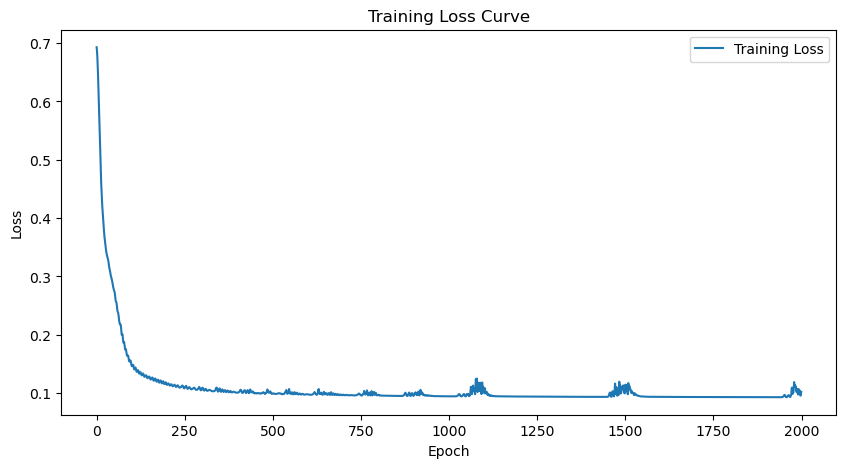

Final Model Accuracy: 80.00%
Final Model F1-score: 0.8061


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_1705388/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


Final Model Accuracy: 80.00%
                  precision    recall  f1-score   support

    infringement       0.84      0.75      0.79       194
non_infringement       0.77      0.85      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380

